In [83]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
import re
from datetime import datetime
import tensorflow_datasets as tfds
import tensorflow as tf
import sklearn
import time

import time
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(1234)

!pip install transformers

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Transformers

The Transformer is a deep machine learning model introduced in 2017, used primarily in the field of natural language processing (NLP). Like recurrent neural networks (RNNs), Transformers are designed to handle ordered sequences of data, such as natural language, for various tasks such as machine translation and text summarization. However, unlike RNNs, Transformers do not require that the sequence be processed in order. So, if the data in question is natural language, the Transformer does not need to process the beginning of a sentence before it processes the end. Due to this feature, the Transformer allows for much more parallelization than RNNs during training.

Since their introduction, Transformers have become the basic building block of most state-of-the-art architectures in NLP, replacing gated recurrent neural network models such as the long short-term memory (LSTM) in many cases. Since the Transformer architecture facilitates more parallelization during training computations, it has enabled training on much more data than was possible before it was introduced. This led to the development of pretrained systems such as BERT (Bidirectional Encoder Representations from Transformers) and GPT-2, which have been trained with huge amounts of general language data prior to being released, and can then be fine-tune trained to specific language tasks.


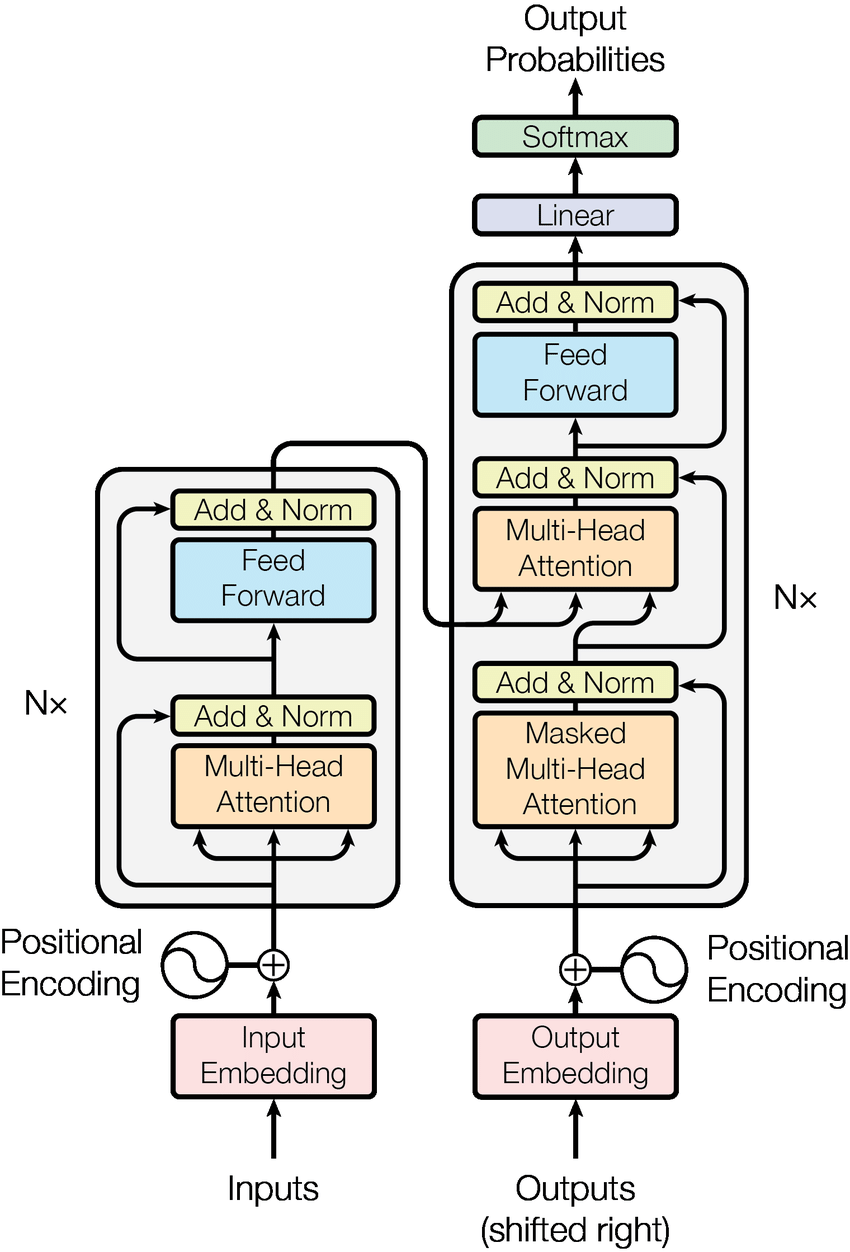

# Transformer in Keras

Lets train a Transformer model, on the problem of question and answering system, that is to be a chatbot.

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of these self-attention layers, as we will see when creating one.

## Prepare Dataset

We will use the conversations in movies and TV shows provided by [Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html), which contains more than 220 thousands conversational exchanges between more than 10k pairs of movie characters, as our dataset.

`movie_conversations.txt` contains list of the conversation IDs and `movie_lines.text` contains the text of assoicated with each conversation ID.

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

### Load and preprocess data

To keep this example simple and fast, we are limiting the maximum number of training samples to`MAX_SAMPLES=25000` and the maximum length of the sentence to be `MAX_LENGTH=40`.

We preprocess our dataset in the following order:
* Extract `MAX_SAMPLES` conversation pairs into list of `questions` and `answers`.
* Preprocess each sentence by removing special characters in each sentence.
* Build tokenizer (map text to ID and ID to text) using [`SubwordTextEncoder`](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder).
* Tokenize each sentence and add `START_TOKEN` and `END_TOKEN` to indicate the start and end of each sentence.
* Filter out sentence that has more than `MAX_LENGTH` tokens.
* Pad tokenized sentences to `MAX_LENGTH`



In [4]:
# Maximum number of samples to preprocess
MAX_SAMPLES = 50000


def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    # adding a start and an end token to the sentence
    return sentence


def load_conversations():
    # dictionary of line id to text
    id2line = {}
    with open(path_to_movie_lines, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        # get conversation in a list of line ID
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    return inputs, outputs


questions, answers = load_conversations()

print('Sample question: {}'.format(questions[20]))
print('Sample answer: {}'.format(answers[20]))

Sample question: i really , really , really wanna go , but i can t . not unless my sister goes .
Sample answer: i m workin on it . but she doesn t seem to be goin for him .


In [5]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [6]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [4, 281, 3, 281, 3, 143, 395, 176, 3, 42, 4, 38, 8191, 2, 37, 873, 27, 2031, 3096, 1]


In [7]:
# Maximum sentence length
MAX_LENGTH = 40


# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [8]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 8333
Number of samples: 44095


### Create `tf.data.Dataset`

Lets use the [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data) to contruct our input pipline in order to utilize features like caching and prefetching to speed up the training process.

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

Target is divided into `decoder_inputs` which padded as an input to the decoder and `cropped_targets` for calculating our loss and accuracy.

In [10]:
BATCH_SIZE = 32
BUFFER_SIZE = 20000

VALIDATION_SPLIT = 0.1

train_answers = answers[:int(len(answers) * VALIDATION_SPLIT)]
train_questions = questions[:int(len(questions) * VALIDATION_SPLIT)]

validation_answers = answers[int(len(answers) * VALIDATION_SPLIT):]
validation_questions = questions[int(len(questions) * VALIDATION_SPLIT):]

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_questions,
        'dec_inputs': train_answers[:, :-1]
    },
    {
        'outputs': train_answers[:, 1:]
    },
))

validation_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': validation_questions,
        'dec_inputs': validation_answers[:, :-1]
    },
    {
        'outputs': validation_answers[:, 1:]
    },
))


train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

validation_dataset = validation_dataset.cache()
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
print(train_dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


## Attention



### Scaled dot product Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V$$

As the softmax normalization is done on the `key`, its values decide the amount of importance given to the `query`.

The output represents the multiplication of the attention weights and the `value` vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `query` and `key` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `query` and `key` should have a mean of 0 and variance of 1, so that we get a gentler softmax.

The mask is multiplied with *-1e9 (close to negative infinity).* This is done because the mask is summed with the scaled matrix multiplication of `query` and `key` and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [12]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

### Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, `query`, `key`, and `value` are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(
            query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # concatenation of heads
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

## Transformer

### Masking



`create_padding_mask` and `create_look_ahead` are helper functions to creating masks to mask out padded tokens, we are going to use these helper functions as `tf.keras.layers.Lambda` layers.

Mask all the pad tokens (value `0`) in the batch to ensure the model does not treat padding as input.

In [14]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [15]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [16]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - \
        tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [17]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

$$PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})$$
$$PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})$$

In [18]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) /
                            tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

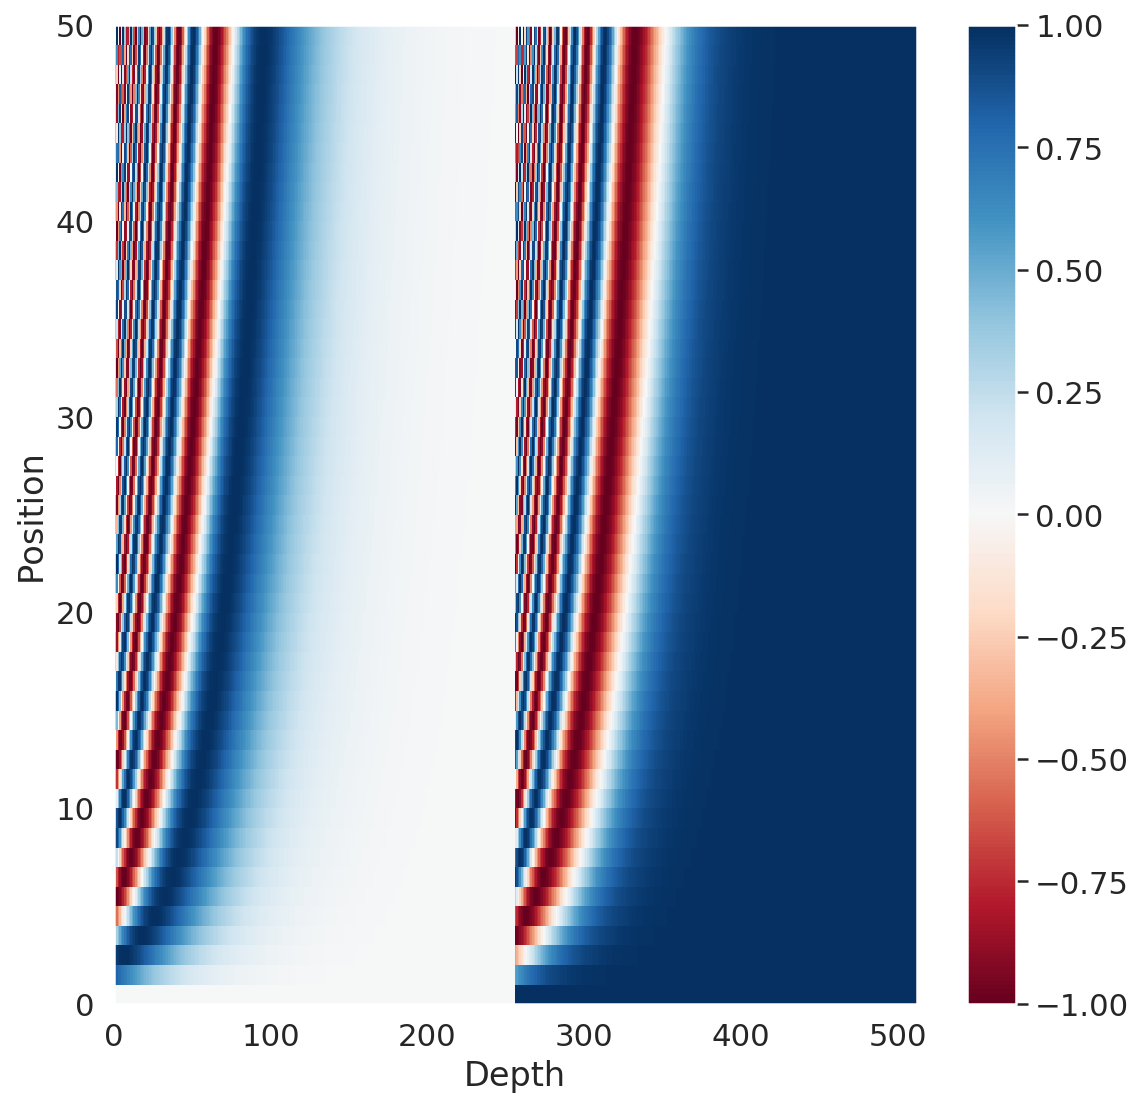

In [19]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask) 
2. 2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

In [20]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

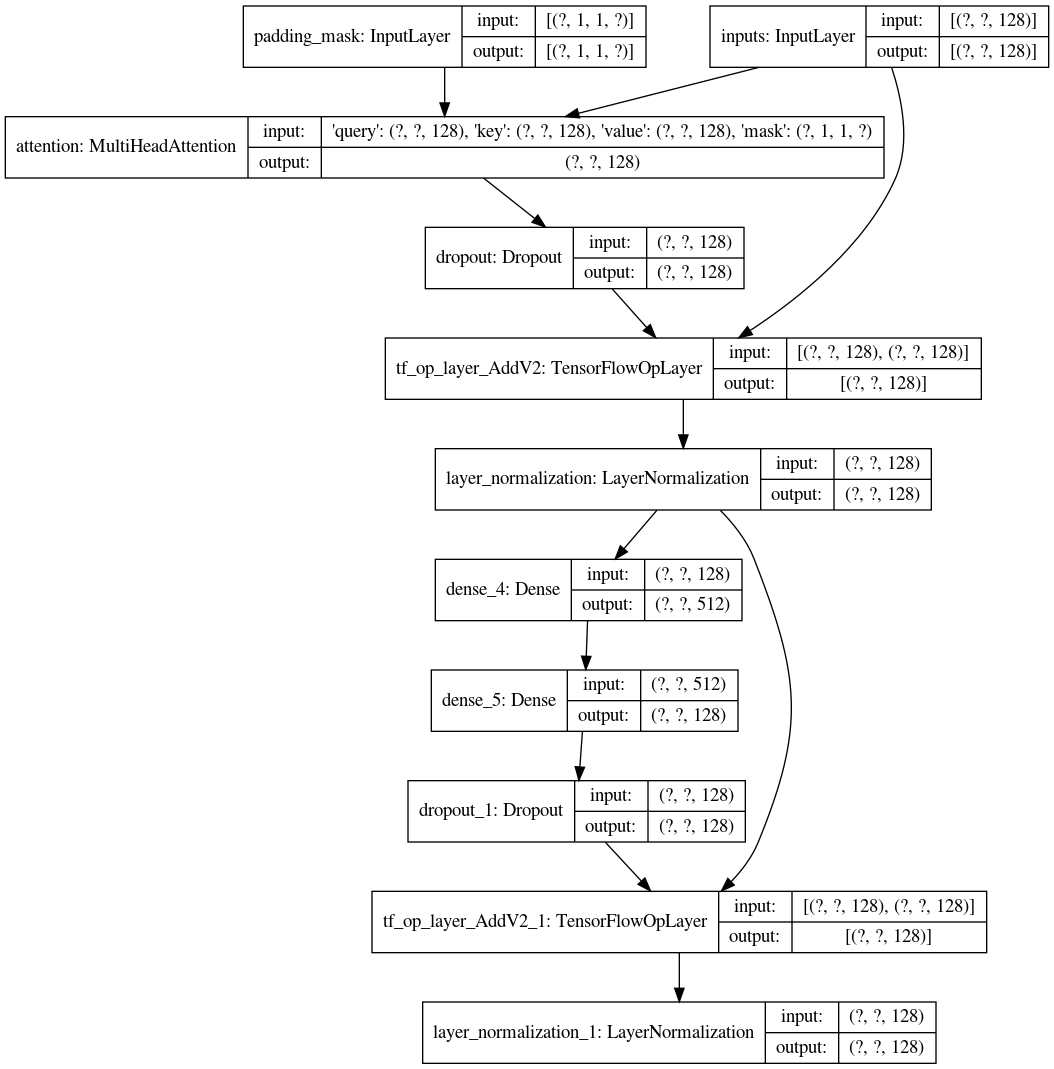

In [21]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

### Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   `num_layers` encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [22]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

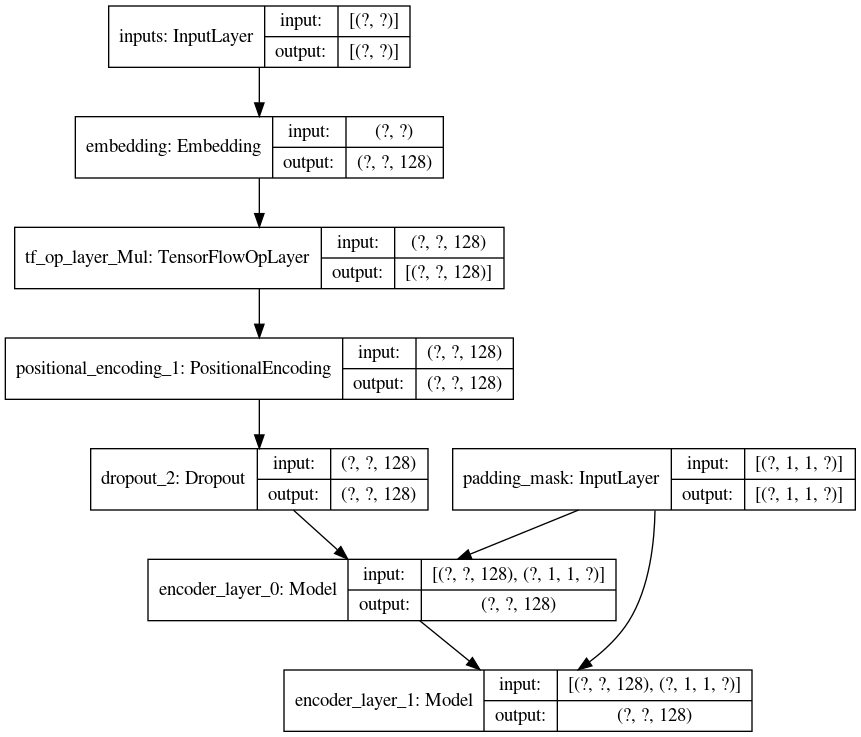

In [23]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
    sample_encoder, to_file='encoder.png', show_shapes=True)

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [24]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

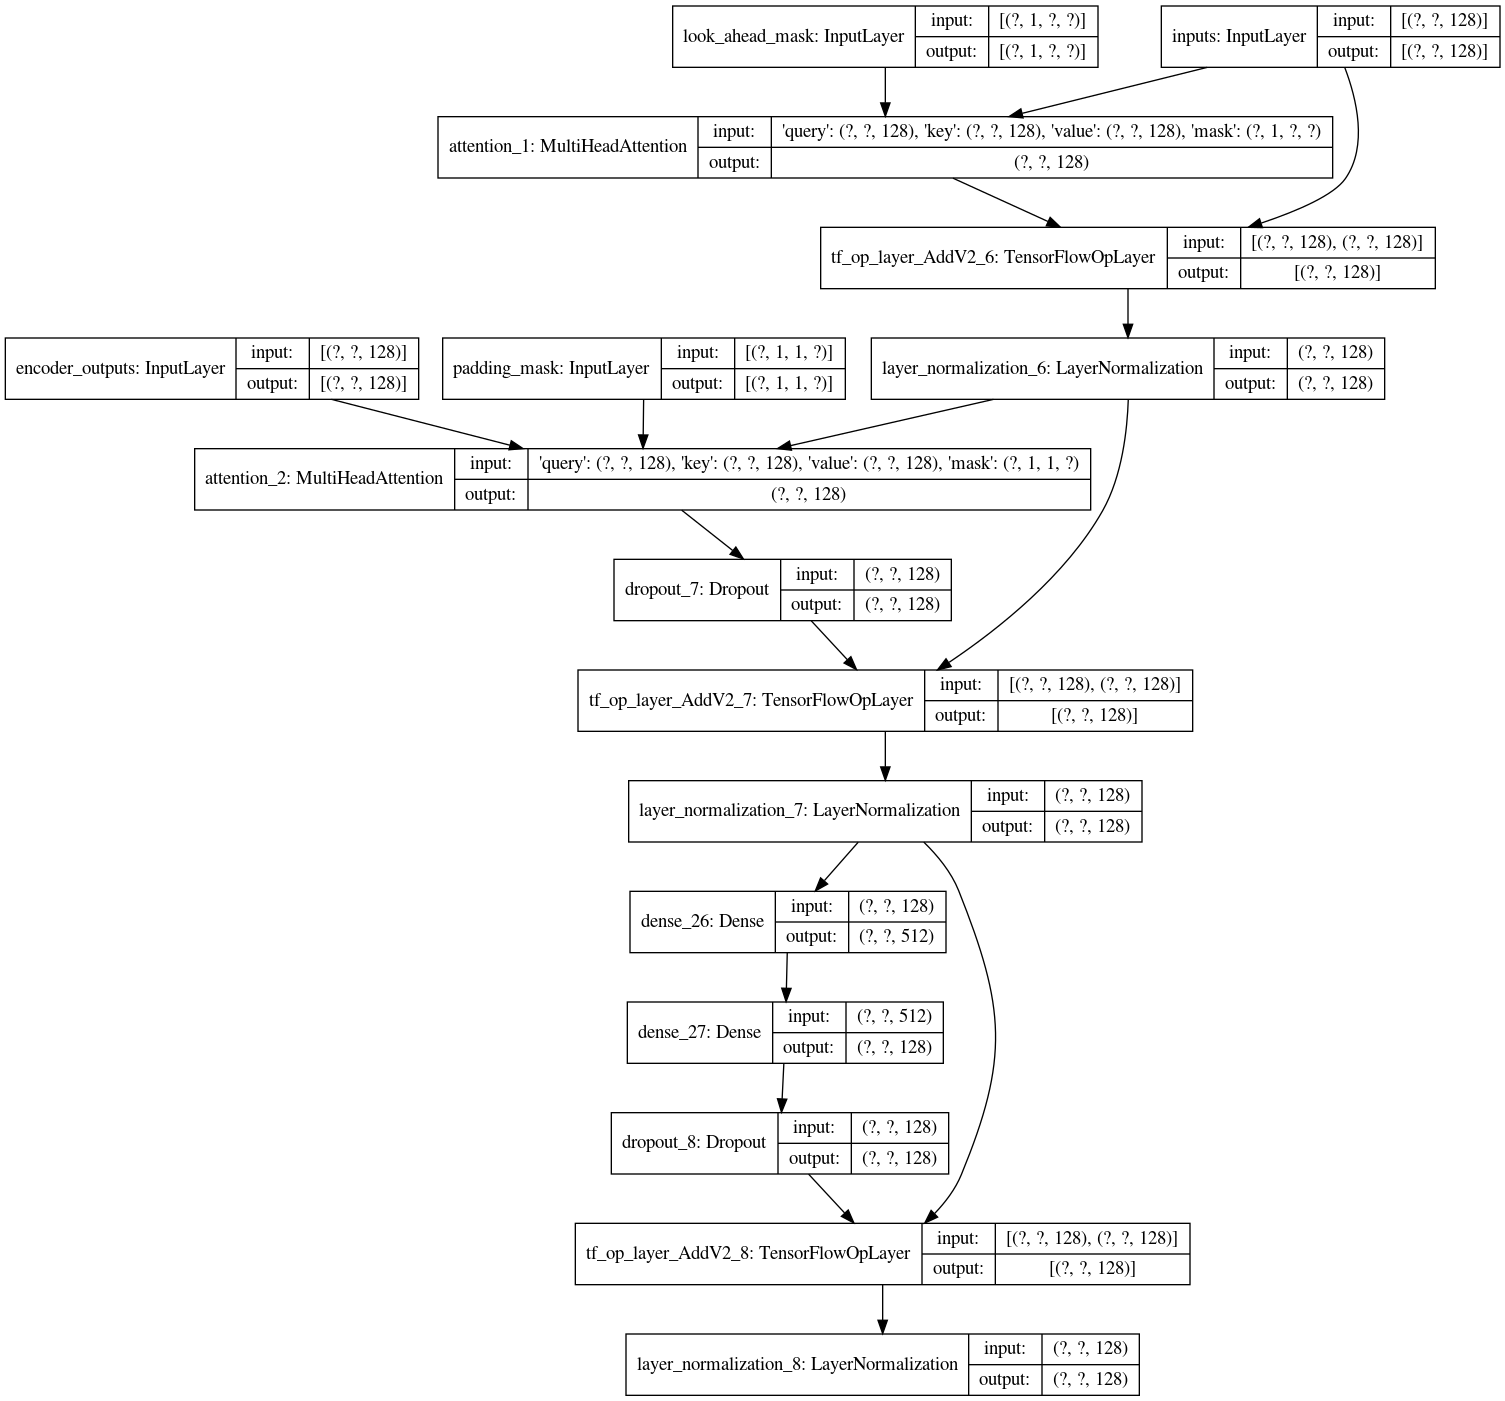

In [25]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [26]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

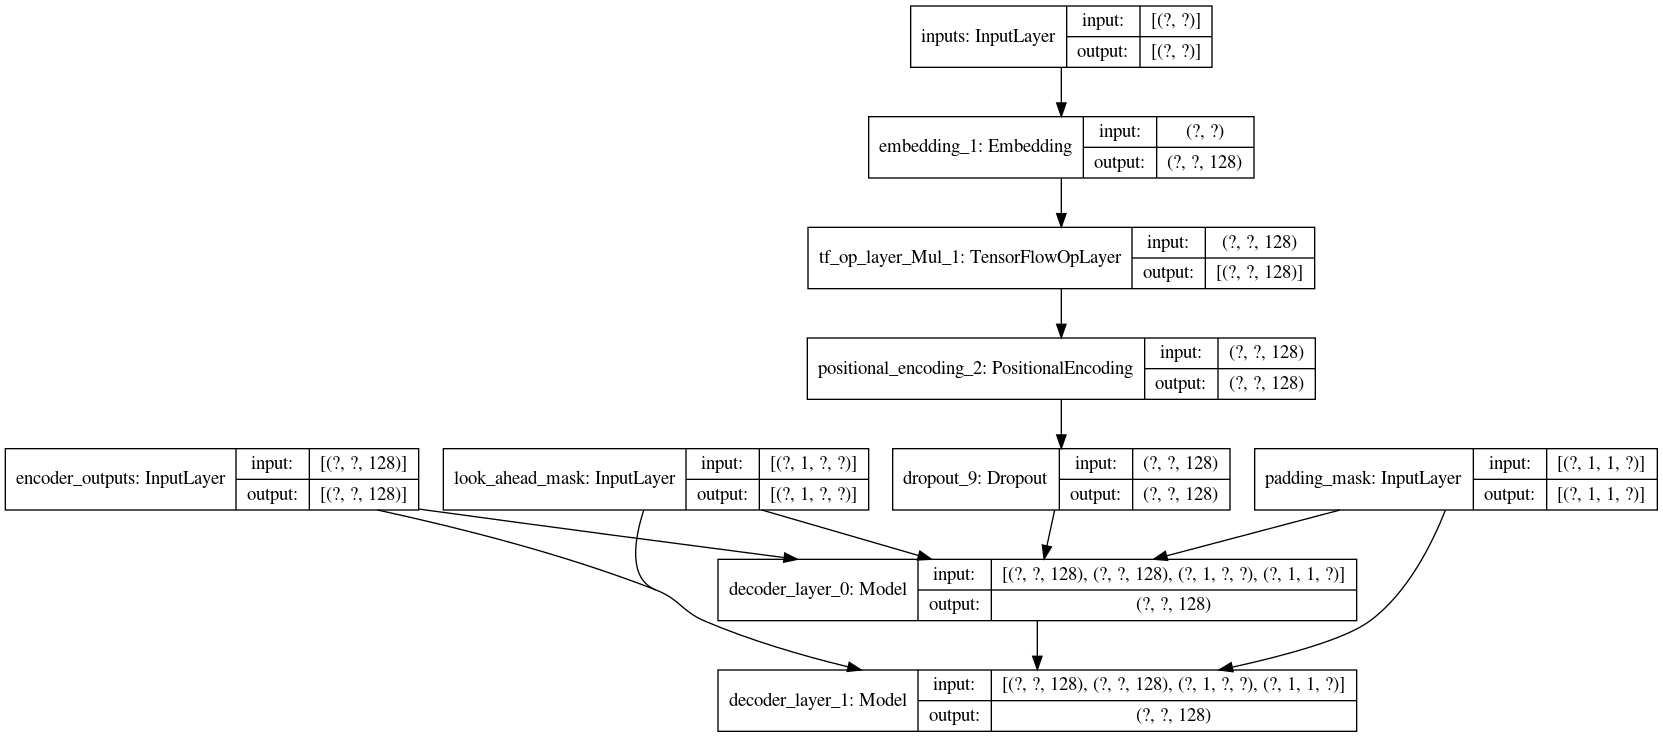

In [27]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [28]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(
        units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

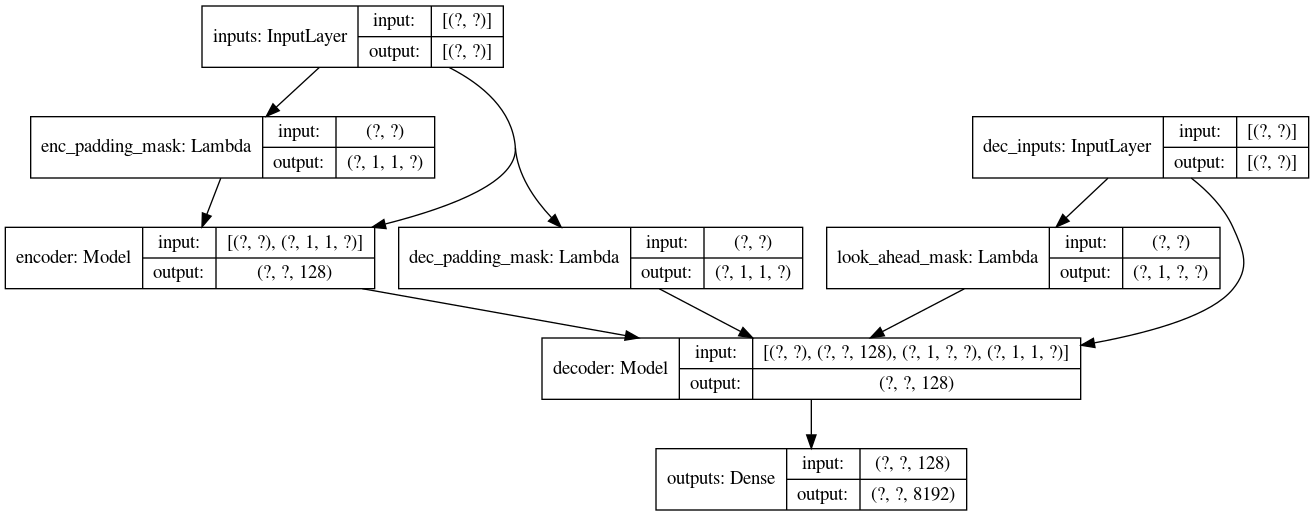

In [29]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

## Train model

### Initialize model

To keep this example small and relatively fast, the values for *num_layers, d_model, and units* have been reduced. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

In [70]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [71]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})$$

In [72]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

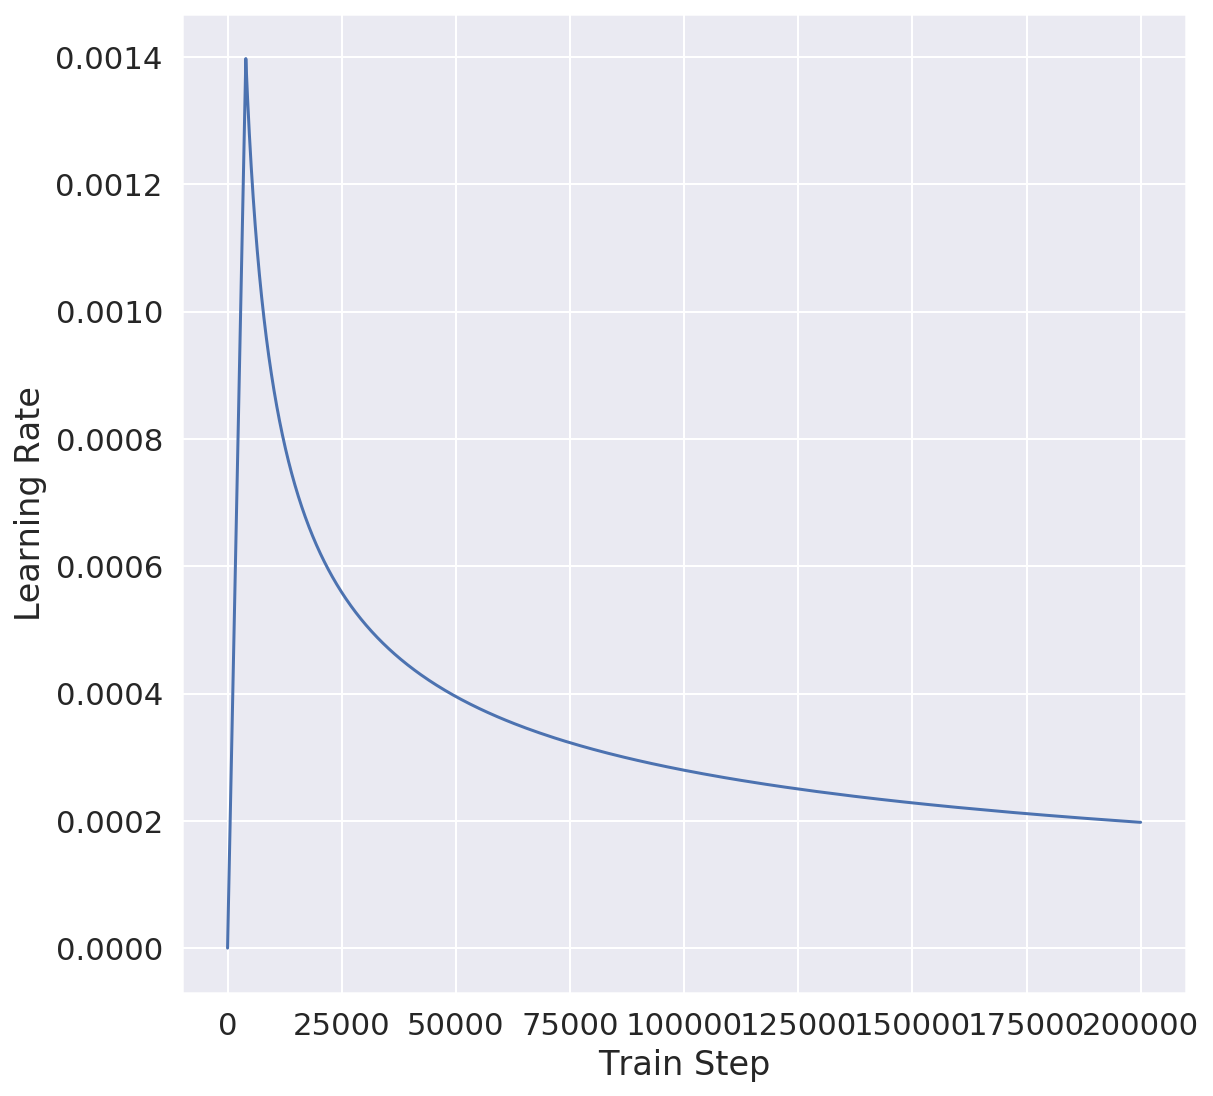

In [73]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Compile Model


In [74]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### Fit model

Train our transformer by simply calling `model.fit()`

In [75]:
EPOCHS = 30

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/30
138/138 [==============================] - 24s 173ms/step - loss: 2.9011 - accuracy: 0.0161 - val_loss: 2.5894 - val_accuracy: 0.0256
Epoch 2/30
138/138 [==============================] - 22s 163ms/step - loss: 2.4826 - accuracy: 0.0256 - val_loss: 2.1357 - val_accuracy: 0.0256
Epoch 3/30
138/138 [==============================] - 23s 163ms/step - loss: 2.0512 - accuracy: 0.0359 - val_loss: 1.8946 - val_accuracy: 0.0469
Epoch 4/30
138/138 [==============================] - 22s 163ms/step - loss: 1.8779 - accuracy: 0.0547 - val_loss: 1.7631 - val_accuracy: 0.0659
Epoch 5/30
138/138 [==============================] - 22s 162ms/step - loss: 1.7255 - accuracy: 0.0696 - val_loss: 1.6805 - val_accuracy: 0.0696
Epoch 6/30
138/138 [==============================] - 22s 163ms/step - loss: 1.6175 - accuracy: 0.0760 - val_loss: 1.6442 - val_accuracy: 0.0736
Epoch 7/30
138/138 [==============================] - 22s 163ms/step - loss: 1.5369 - accuracy: 0.0813 - val_loss: 1.6225 - val_ac

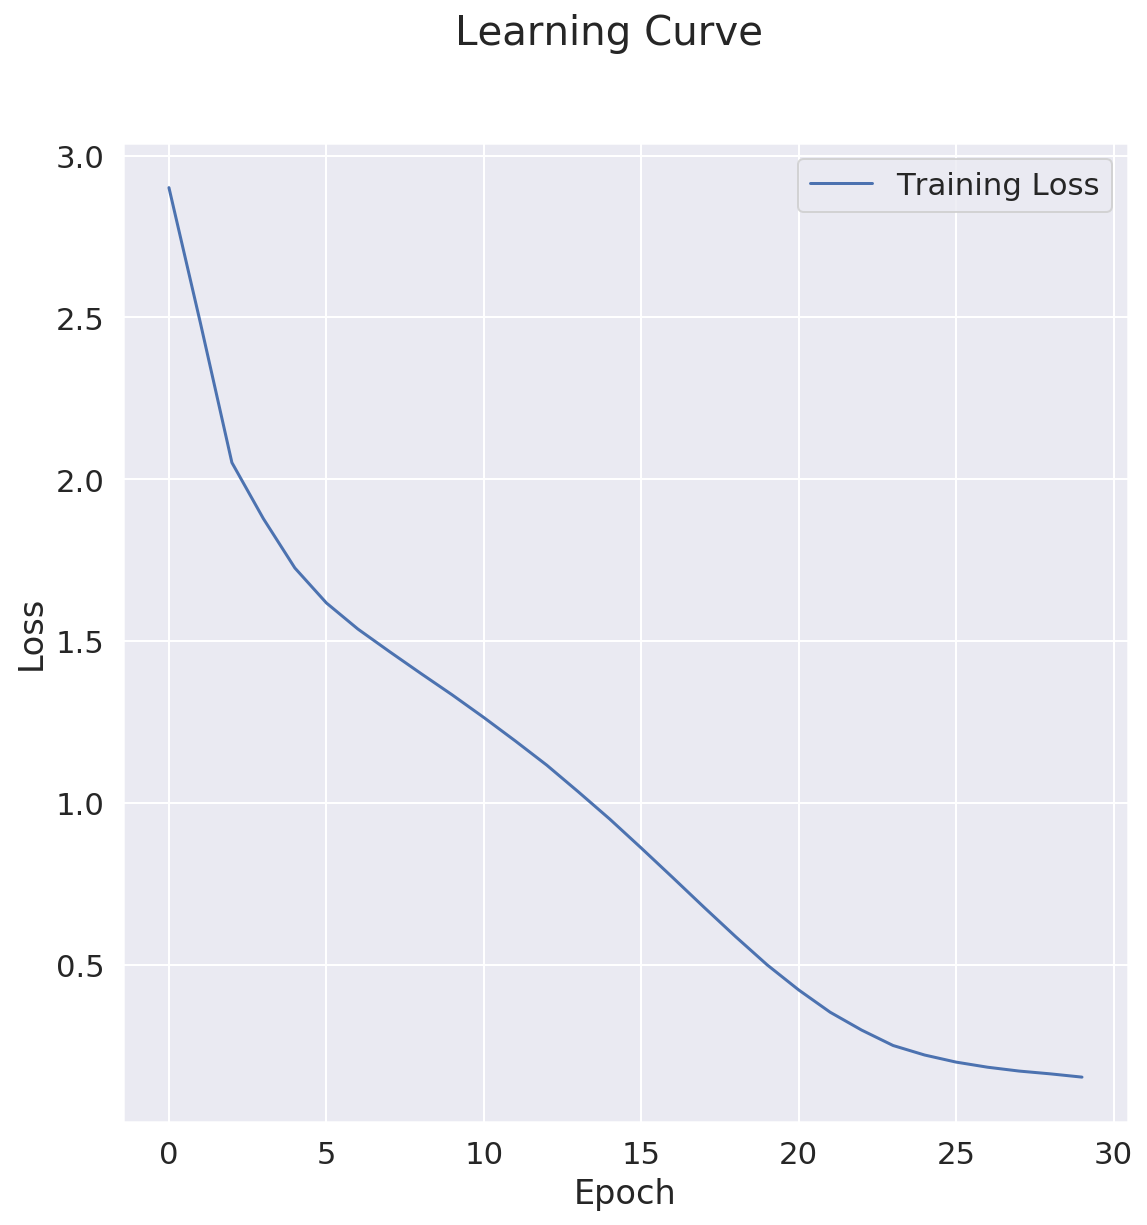

In [76]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
fig = plt.Figure(figsize=(15, 8))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.suptitle('Learning Curve')
plt.legend(['Training Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Evaluate and predict

The following steps are used for evaluation:

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`. 
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity and trained on a subset of the full dataset, hence its performance can be further improved.

In [77]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)

    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

Let's test our model!

In [78]:
output = predict('Where have you been?')

Input: Where have you been?
Output: nowhere . . . hi , daddy .


In [79]:
output = predict("It's a trap")

Input: It's a trap
Output: it was my decision , not his .


In [80]:
# feed the model with its previous output
sentence = 'I am not crazy, my mother had me tested.'
for _ in range(5):
    sentence = predict(sentence)
    print('')

Input: I am not crazy, my mother had me tested.
Output: yeah , or turn you into toast .

Input: yeah , or turn you into toast .
Output: i m sure that s settled . . . now like you re a chance to see shit . it s just something you re his back , i can t date i m gonna arrest me .

Input: i m sure that s settled . . . now like you re a chance to see shit . it s just something you re his back , i can t date i m gonna arrest me .
Output: yeah , i think so . . . well , i didn t want you to go out with me . just told me to go out of my life .

Input: yeah , i think so . . . well , i didn t want you to go out with me . just told me to go out of my life .
Output: you re done , on me . end of story .

Input: you re done , on me . end of story .
Output: it ain t cool . it s a long shot . i heard he s a day . for my thing could use two . i m gonna call back .



We have implemented a Transformer in TensorFlow 2.0 in around 500 lines of code. The transformer allowed the equivalent *Image Net* moment in 2018 & 2019, with being the best performing model architecture across a broad range of NLP benchmark problems. It is now standard pratice to use one a transformer model pre-trained and apply it to our problem, as transfer learning for NLP. As such there are a few models, that we should be aware of that we can use as a pre-trained model.

# Model Case Studies

* `BERT` (from Google) released with the paper BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova.
* `GPT` (from OpenAI) released with the paper Improving Language Understanding by Generative Pre-Training by Alec Radford, Karthik Narasimhan, Tim Salimans and Ilya Sutskever.
* `GPT-2` (from OpenAI) released with the paper Language Models are Unsupervised Multitask Learners by Alec Radford*, Jeffrey Wu*, Rewon Child, David Luan, Dario Amodei** and Ilya Sutskever**.
* `Transformer-XL` (from Google/CMU) released with the paper Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context by Zihang Dai*, Zhilin Yang*, Yiming Yang, Jaime Carbonell, Quoc V. Le, Ruslan Salakhutdinov.
* `XLNet` (from Google/CMU) released with the paper XLNet: Generalized Autoregressive Pretraining for Language Understanding by Zhilin Yang*, Zihang Dai*, Yiming Yang, Jaime Carbonell, Ruslan Salakhutdinov, Quoc V. Le.
* `XLM` (from Facebook) released together with the paper Cross-lingual Language Model Pretraining by Guillaume Lample and Alexis Conneau.
* `RoBERTa` (from Facebook), released together with the paper a Robustly Optimized BERT Pretraining Approach by Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov.
* `DistilBERT` (from HuggingFace) released together with the paper DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter by Victor Sanh, Lysandre Debut and Thomas Wolf. The same method has been applied to compress GPT2 into DistilGPT2.
* `CTRL` (from Salesforce), released together with the paper CTRL: A Conditional Transformer Language Model for Controllable Generation by Nitish Shirish Keskar*, Bryan McCann*, Lav R. Varshney, Caiming Xiong and Richard Socher.
* `CamemBERT` (from FAIR, Inria, Sorbonne Université) released together with the paper CamemBERT: a Tasty French Language Model by Louis Martin, Benjamin Muller, Pedro Javier Ortiz Suarez, Yoann Dupont, Laurent Romary, Eric Villemonte de la Clergerie, Djame Seddah, and Benoît Sagot.
* `ALBERT` (from Google Research), released together with the paper a ALBERT: A Lite BERT for Self-supervised Learning of Language Representations by Zhenzhong Lan, Mingda Chen, Sebastian Goodman, Kevin Gimpel, Piyush Sharma, Radu Soricut.
* `XLM-RoBERTa` (from Facebook AI), released together with the paper Unsupervised Cross-lingual Representation Learning at Scale by Alexis Conneau*, Kartikay Khandelwal*, Naman Goyal, Vishrav Chaudhary, Guillaume Wenzek, Francisco Guzmán, Edouard Grave, Myle Ott, Luke Zettlemoyer and Veselin Stoyanov.
* `FlauBERT` (from CNRS) released with the paper FlauBERT: Unsupervised Language Model Pre-training for French by Hang Le, Loïc Vial, Jibril Frej, Vincent Segonne, Maximin Coavoux, Benjamin Lecouteux, Alexandre Allauzen, Benoît Crabbé, Laurent Besacier, Didier Schwab.


Let us use a pre-trained `BERT` model, and create a fine-tuned model for a classification task, here to classify whether an based on two input sentences one is a paraphrase of the other. We can use the `transformers` [library](https://huggingface.co/transformers/) here, to load the pre-trained models listed above easily.

In [107]:
import tensorflow as tf
import tensorflow_datasets
from transformers import *

# Load dataset, tokenizer, model from pretrained model/vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased')
data = tensorflow_datasets.load('glue/mrpc')

# Prepare dataset for GLUE as a tf.data.Dataset instance
train_dataset = glue_convert_examples_to_features(
    data['train'], tokenizer, max_length=128, task='mrpc')
valid_dataset = glue_convert_examples_to_features(
    data['validation'], tokenizer, max_length=128, task='mrpc')
train_dataset = train_dataset.shuffle(100).batch(32).repeat(2)
valid_dataset = valid_dataset.batch(64)

# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(
    learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

INFO:absl:Load dataset info from /home/ubuntu/tensorflow_datasets/glue/mrpc/1.0.0
INFO:absl:Reusing dataset glue (/home/ubuntu/tensorflow_datasets/glue/mrpc/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/ubuntu/tensorflow_datasets/glue/mrpc/1.0.0


Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_161 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [108]:
EPOCHS = 50

early = tf.keras.callbacks.EarlyStopping('val_loss', patience=3)

# Train and evaluate using tf.keras.Model.fit()
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    callbacks=[early])

Epoch 1/50
230/230 [==============================] - 69s 299ms/step - loss: 0.4480 - accuracy: 0.7767 - val_loss: 0.3967 - val_accuracy: 0.8382
Epoch 2/50
230/230 [==============================] - 66s 287ms/step - loss: 0.1290 - accuracy: 0.9530 - val_loss: 0.7636 - val_accuracy: 0.8309
Epoch 3/50
230/230 [==============================] - 66s 287ms/step - loss: 0.0512 - accuracy: 0.9834 - val_loss: 0.6594 - val_accuracy: 0.8652
Epoch 4/50
230/230 [==============================] - 66s 287ms/step - loss: 0.0274 - accuracy: 0.9922 - val_loss: 0.6447 - val_accuracy: 0.8358


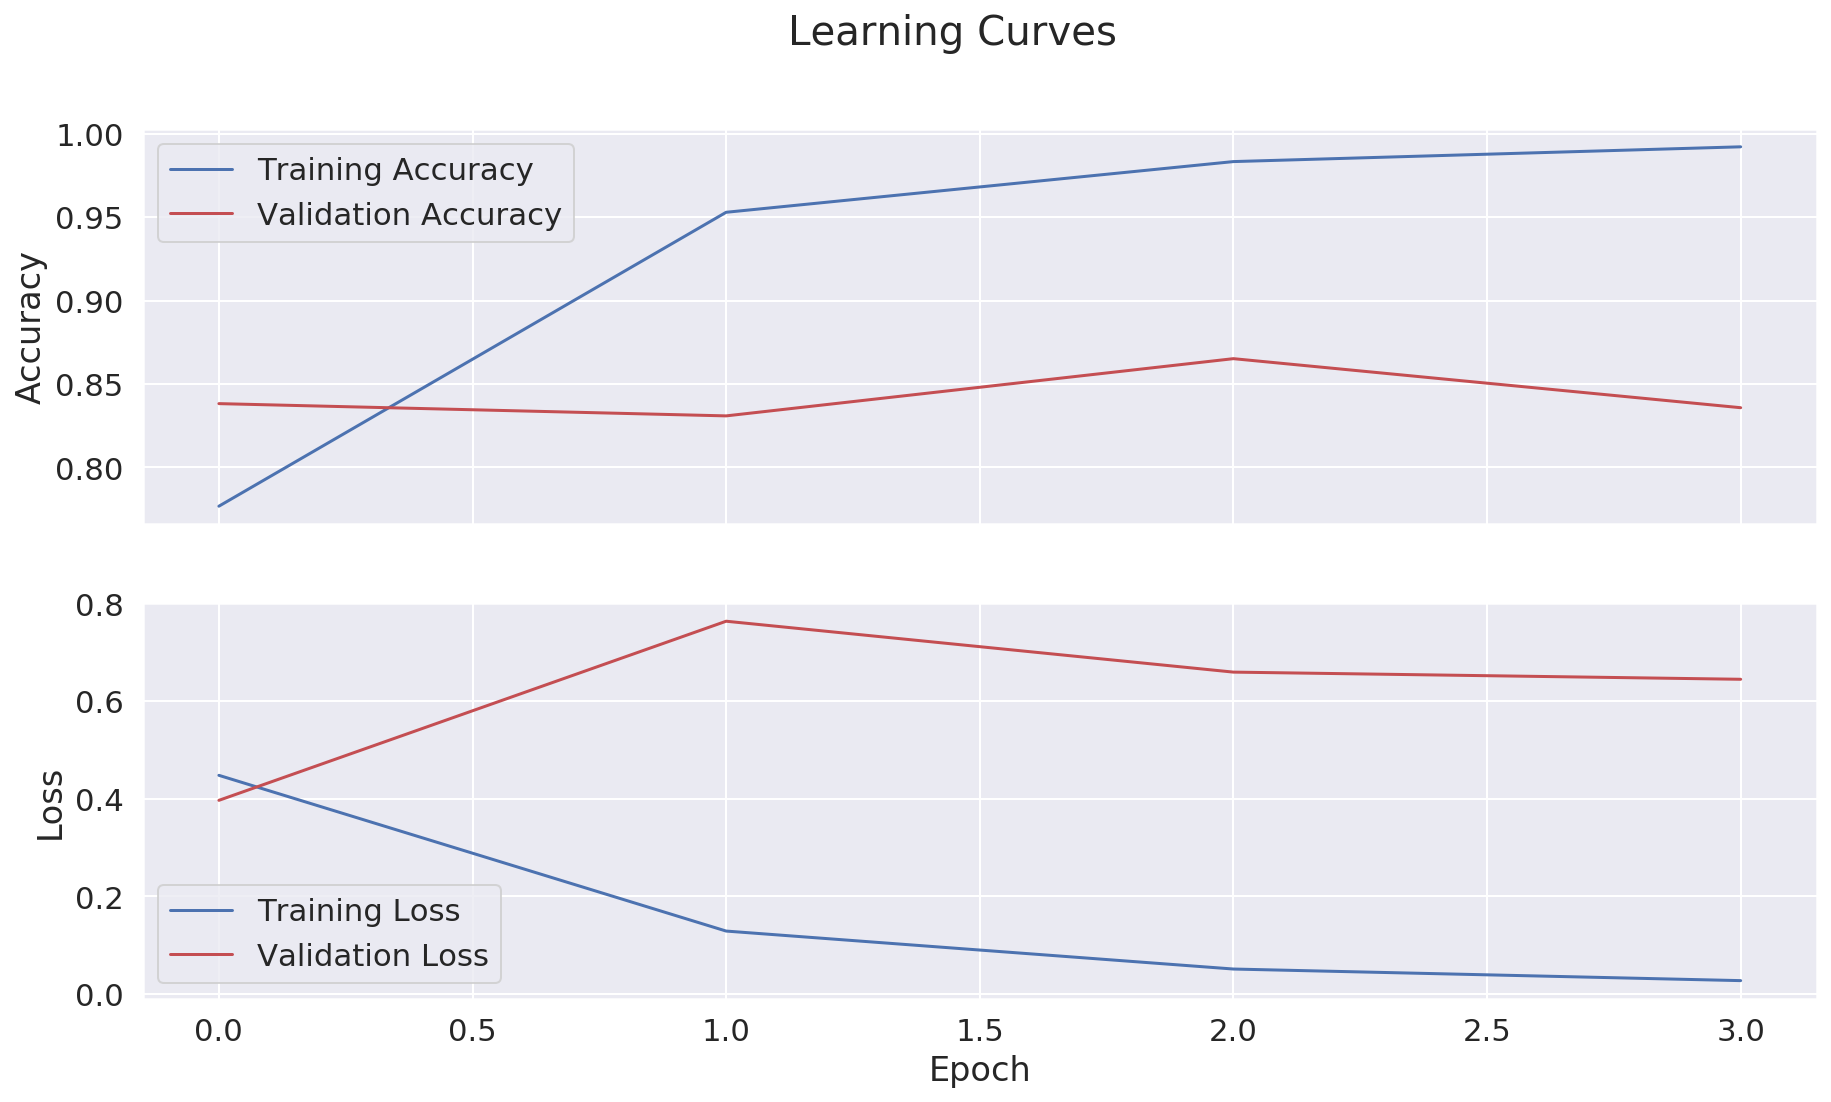

In [110]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
fig, axes = plt.subplots(2, sharex=True, figsize=(15, 8))
fig.suptitle('Learning Curves')

epochs_to_mean = 1

axes[0].set_ylabel("Accuracy")
axes[0].plot(history_df['accuracy'].rolling(epochs_to_mean).mean(), 'b')
axes[0].plot(history_df['val_accuracy'].rolling(epochs_to_mean).mean(), '-r')
axes[0].legend(['Training Accuracy', 'Validation Accuracy'])

axes[1].set_ylabel("Loss")
axes[1].plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
axes[1].plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
axes[1].legend(['Training Loss', 'Validation Loss'])
axes[1].set_xlabel("Epoch")

plt.show()

In [130]:
for sample in iter(data['validation'].take(20)):
    inputs = tokenizer.encode_plus(str(sample['sentence1']), str(sample['sentence2']), add_special_tokens=True, return_tensors='tf')
    predict = model(inputs['input_ids'], token_type_ids=inputs['token_type_ids'])[0].numpy().argmax().item()
    print("\nTrue Label : {label} - Predicted Label: {predict}\nSentence 1: {sentence1}\nSentence 2: {sentence2}".format(**dict(sample, predict=predict)))


True Label : 1 - Predicted Label: 1
Sentence 1: b"The show 's closure affected third-quarter earnings per share by a penny ."
Sentence 2: b'The company said this impacted earnings by a penny a share .'

True Label : 1 - Predicted Label: 1
Sentence 1: b'Terri Schiavo , 39 , underwent the procedure at the Tampa Bay area hospice where she has been living for several years , said her father , Bob Schindler .'
Sentence 2: b'The tube was removed Wednesday from Terri Schiavo , 39 , at the Tampa Bay-area hospice where she has lived for several years .'

True Label : 0 - Predicted Label: 0
Sentence 1: b'The study , published Monday in the journal Molecular Brain Research , is likely to also apply to humans , its authors said .'
Sentence 2: b'The study , conducted on the brains of developing mice , was being published today in the journal Molecular Brain Research .'

True Label : 1 - Predicted Label: 1
Sentence 1: b'It also offers a built-in NAND flash boot loader so that high-density NAND flas